In [30]:
import anndata as ad
import pandas as pd
import numpy as np
import muon as mu   #This one
import scanpy as sc

import os


In [34]:
data_dir = "data/pbmc10k"
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)


In [16]:
# Remove file prefixes if any
prefix = "pbmc_granulocyte_sorted_10k_"
for file in os.listdir(data_dir):
    if file.startswith(prefix):
        new_filename = file[len(prefix):]
        os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

In [18]:
#Import HDF5 with muon

#Load scATACseq features

mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_feature_bc_matrix.h5"))  

#Load scRNAseq features
#mdata = mu.read_10x_h5('data/pbmc10k/pbmc_10k_v3_raw_feature_bc_matrix.h5')  

#Not sure if should cache here ^

mdata.var_names_make_unique()
mdata


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from data/pbmc10k/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/gugu/mambaforge/envs/bioinfo/lib/python3.10/site-packages/mudata/_core/mudata.py:405: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from data/pbmc10k/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: data/pbmc10k/atac_fragments.tsv.gz
pysam is not available. It is required to work with the fragments file.                 Install pysam from PyPI (`pip install pysam`)                 or from GitHub (`pip install git+https://github.com/pysam-developers/pysam`)


MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac'

In [21]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

Mitochondrial genes: 
 
                gene_ids    feature_types  genome interval    mt  \
MT-ND1   ENSG00000198888  Gene Expression  GRCh38       NA  True   
MT-ND2   ENSG00000198763  Gene Expression  GRCh38       NA  True   
MT-CO1   ENSG00000198804  Gene Expression  GRCh38       NA  True   
MT-CO2   ENSG00000198712  Gene Expression  GRCh38       NA  True   
MT-ATP8  ENSG00000228253  Gene Expression  GRCh38       NA  True   
MT-ATP6  ENSG00000198899  Gene Expression  GRCh38       NA  True   
MT-CO3   ENSG00000198938  Gene Expression  GRCh38       NA  True   
MT-ND3   ENSG00000198840  Gene Expression  GRCh38       NA  True   
MT-ND4L  ENSG00000212907  Gene Expression  GRCh38       NA  True   
MT-ND4   ENSG00000198886  Gene Expression  GRCh38       NA  True   
MT-ND5   ENSG00000198786  Gene Expression  GRCh38       NA  True   
MT-ND6   ENSG00000198695  Gene Expression  GRCh38       NA  True   
MT-CYB   ENSG00000198727  Gene Expression  GRCh38       NA  True   

         n_cells_by_cou

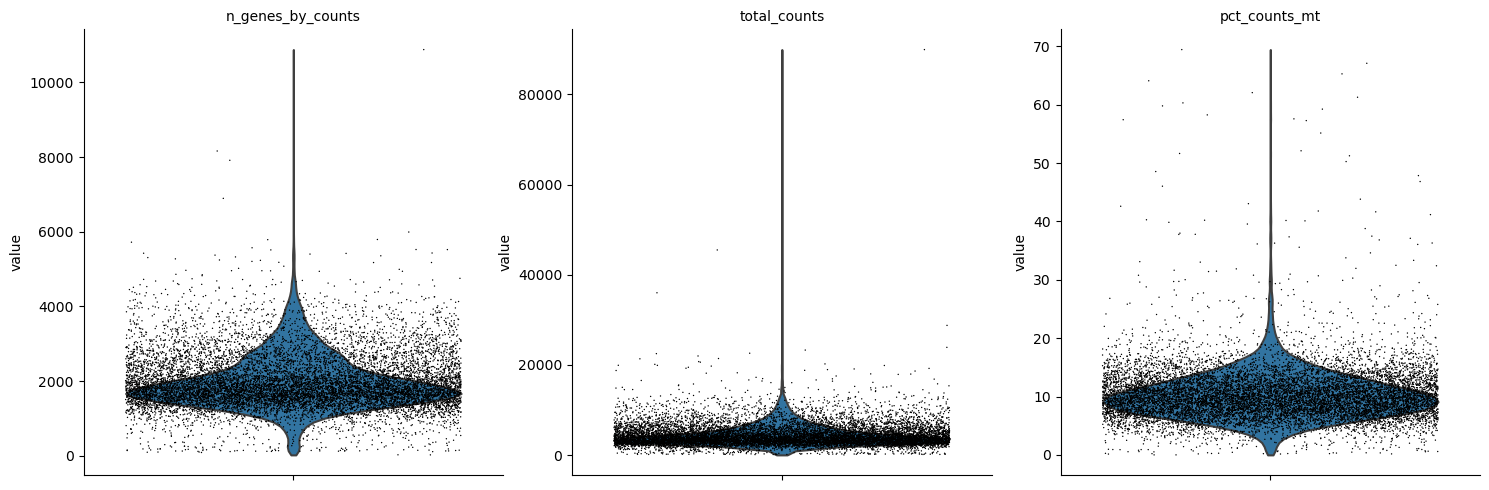

In [35]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')
print('Mitochondrial genes: \n ')

print(rna.var[rna.var['mt'] == True])
#List of mitochondrial genes. 

sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, inplace=True)
sc.pl.violin(rna,  ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [36]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)

<h3>Quality Control of RNA</h3>

In [37]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x : x < 20)

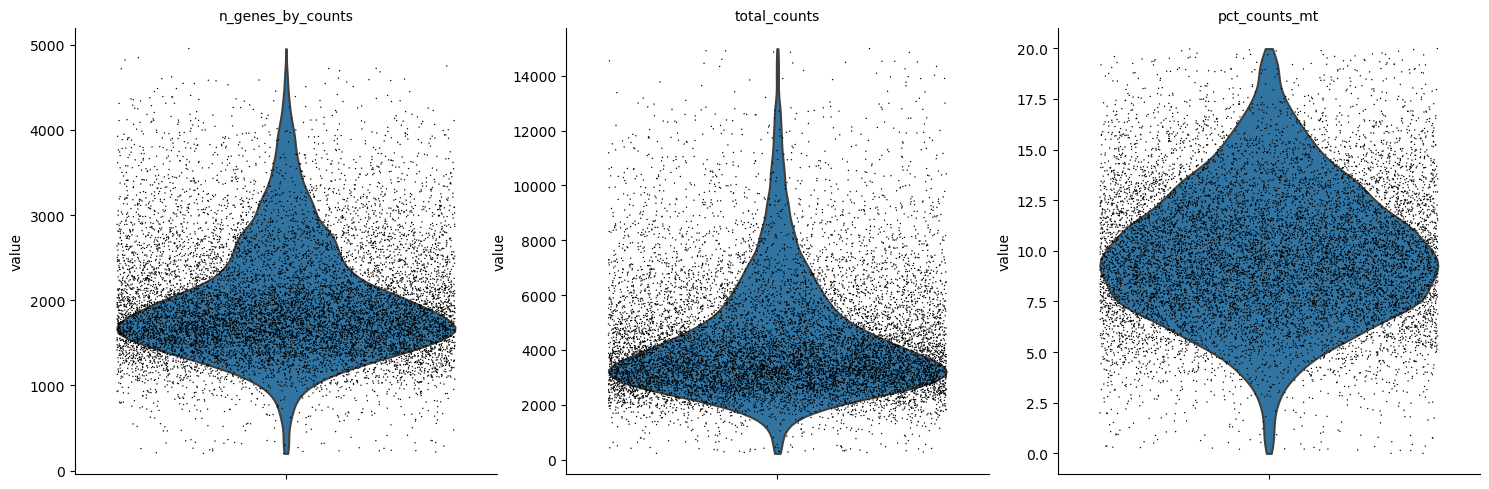

In [45]:
sc.pl.violin(rna,  ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

<h3> Normalisation </h3>
Fit mRNA counts to a Counts Per Million normalization. Still includes mtRNA because we haven't filtered that out.
<hr style="color:#ff9966">


In [47]:
sc.pp.normalize_total(rna, target_sum=10000) #CPM normilization, 1e4

sc.pp.log1p(rna)

normalizing counts per cell
    finished (0:00:00)


<h3> Feature Selection </h3>
Select/Annotate HVGs
<hr style="color:#ff9966">


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


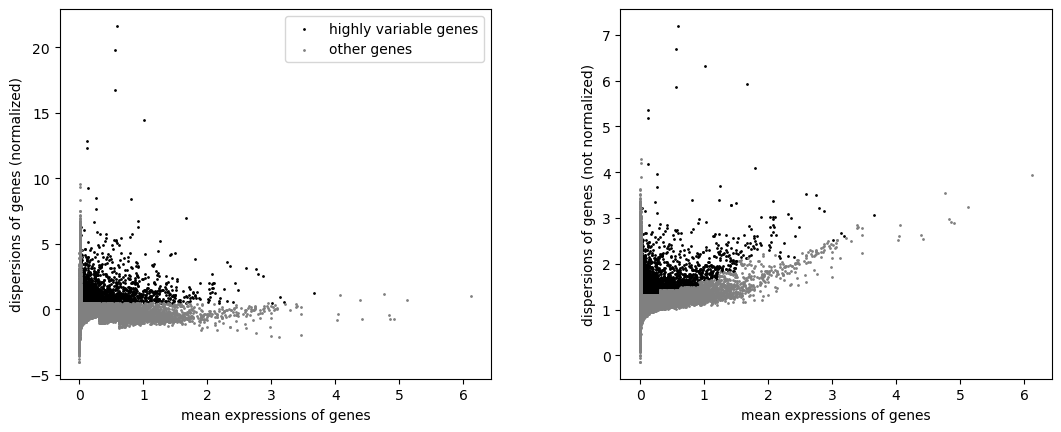

In [52]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
#Annotates HVGs, genes that are correlated with high cell-to-cell variation in terms of RNA.
#Variance needs to be stabilized prior to selection of genes. Since scRNA has strong mean-variance relationship
#
sc.pl.highly_variable_genes(rna)

In [54]:
np.sum(rna.var.highly_variable)

3026

<h3 style="color:#ff9966">Scaling</h3>
<hr style="color:#ff9966">



In [57]:
rna.raw = rna 

#Scale the log-normalised counts in a .raw slot

#Scale the log-normd RNA counts to have a 0 mean and 0 unit variance
sc.pp.scale(rna, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


<h3 style="color:#ff9966">Analysis</h3>
<hr style="color:#ff9966">

Having filtered low-quality cells, normalised the counts matrix, and performed feature selection, we can already use this data for multimodal integration (ATACseq).
However it is usually a good idea to study individual modalities as well. Below we run PCA on the scaled matrix,
compute cell neighbourhood graph, and perform clustering to define cell types.


In [58]:
#Read until page 83